# NLP with Disaster Tweets

This notebook addresses a classification challenge on disaster-related tweets. The goal is to leverage NLP techniques and deep learning to identify real disaster tweets.

This challenge involves analyzing tweets to determine if they are about actual disasters. In real-world applications, such a model can help organizations quickly identify and respond to emergencies. Natural Language Processing (NLP) techniques are used to handle and extract meaningful features from textual data.


In [11]:
%pip install nltk

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import re
import nltk

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')


Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
VOCAB_LIMIT = 10000
SEQUENCE_LEN = 100
EMBED_SIZE = 200
VAL_SPLIT = 0.2
SEED = 42
BATCH = 32
EPOCH_MAX = 20


### Data Inspection

In [13]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print("Initial Dataset Info:")
print("-" * 40)
print("Train set dimensions:", df_train.shape)
print("Test set dimensions:", df_test.shape)
print("Train columns:", df_train.columns.tolist())
print("\nNull values in train:\n", df_train.isnull().sum())
print("\nTweet samples:\n", df_train['text'].head())


Initial Dataset Info:
----------------------------------------
Train set dimensions: (7613, 5)
Test set dimensions: (3263, 4)
Train columns: ['id', 'keyword', 'location', 'text', 'target']

Null values in train:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Tweet samples:
 0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object


## Exploratory Data Analysis (EDA)

This section is dedicated to understanding and preparing the data. We inspect data distributions, perform visualizations, and execute data cleaning procedures. The goal is to discover patterns, spot anomalies, and decide on the next steps for feature engineering.

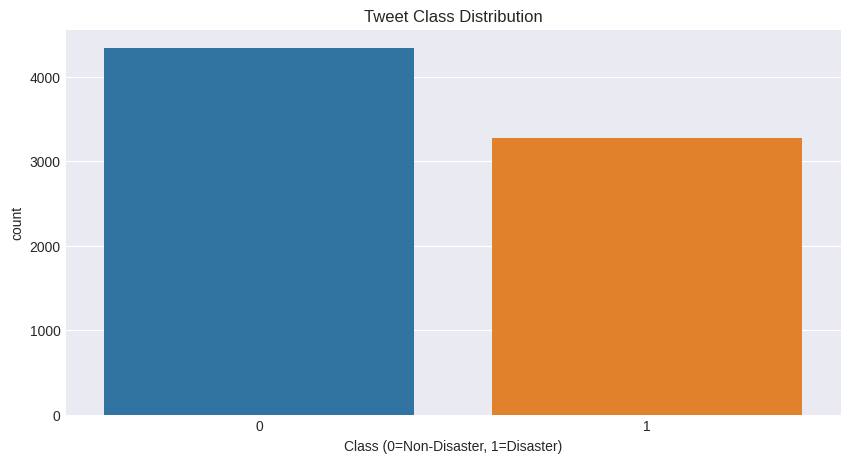

Class percentage breakdown:
target
0    57.0
1    43.0
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


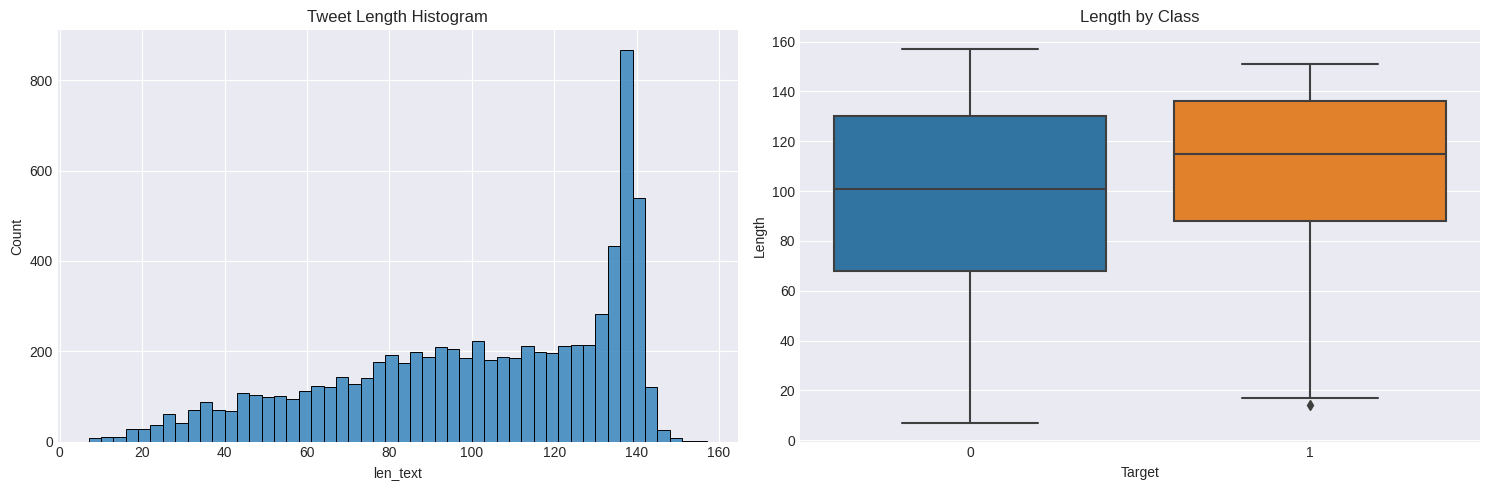

In [14]:
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(10, 5))
sns.countplot(data=df_train, x='target')
plt.title('Tweet Class Distribution')
plt.xlabel('Class (0=Non-Disaster, 1=Disaster)')
plt.show()

print("Class percentage breakdown:")
print(df_train['target'].value_counts(normalize=True).round(3) * 100)

df_train['len_text'] = df_train['text'].str.len()
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='len_text', bins=50)
plt.title('Tweet Length Histogram')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_train, x='target', y='len_text')
plt.title('Length by Class')
plt.xlabel('Target')
plt.ylabel('Length')

plt.tight_layout()
plt.show()


From the plots above we can see that we have a relatively even distribution of both non-disaster tweets and disaster tweets.

We can also see that the disaster tweets tend to be slightly longer than the non-disaster ones. 

### Data Cleaning

In [15]:
def clean_text(raw_text):
    if pd.isna(raw_text):
        return ''
    raw_text = raw_text.lower()
    raw_text = re.sub(r'http\S+|www\S+|https\S+', '', raw_text)
    raw_text = re.sub(r'@\w+', '', raw_text)
    raw_text = re.sub(r'#(\w+)', r'\1', raw_text)
    raw_text = re.sub(r'[^\w\s]', '', raw_text)
    raw_text = re.sub(r'\d+', '', raw_text)
    raw_text = ' '.join(raw_text.split())
    
    stop_words_set = set(stopwords.words('english'))
    tokenized = word_tokenize(raw_text)
    filtered = [word for word in tokenized if word not in stop_words_set]
    
    return ' '.join(filtered)

df_train['text_clean'] = df_train['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)

for i in range(3):
    print(f"\nOriginal: {df_train['text'].iloc[i]}")
    print(f"Cleaned : {df_train['text_clean'].iloc[i]}")



Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned : deeds reason earthquake may allah forgive us

Original: Forest fire near La Ronge Sask. Canada
Cleaned : forest fire near la ronge sask canada

Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Cleaned : residents asked shelter place notified officers evacuation shelter place orders expected


## Model Architecture

My model architecture is specifically designed for binary text classification and comprises several key components:

#### Embedding Layer:

The first layer converts input token sequences into dense vector representations. It maps each word (or token) into a fixed-size vector space, making it easier for the model to learn semantic relationships.

#### Bidirectional LSTM Layers:

Two stacked Bidirectional LSTM layers follow. The first Bidirectional LSTM (with 64 units) returns the full sequence output, allowing the subsequent layer to access context from both time directions. The second Bidirectional LSTM (with 32 units) further processes these outputs, helping the model capture complex sequential patterns in the text.

#### Dropout Layers:

Dropout is applied after the LSTM layers and in between dense layers to prevent overfitting by randomly omitting a fraction of neurons during training.

#### Dense Layers:

A series of fully connected (Dense) layers with ReLU activation refine the learned features. These layers progressively reduce the dimensionality, preparing the final decision for classification.

#### Output Layer:

The final layer is a Dense layer with a single neuron and a sigmoid activation function, which outputs a probability score for the binary classification task.

#### Compilation and Callbacks:

The model is compiled using the Adam optimizer with binary cross-entropy loss and set to measure accuracy. Additional callbacks like EarlyStopping and ReduceLROnPlateau are included to monitor the validation accuracy, prevent overfitting, and adjust learning rates during training.
This architecture effectively combines embedding, sequence processing via LSTMs, and dense layers to tackle the challenge of classifying text data with an emphasis on leveraging context and sequence information.

In [16]:
text_encoder = Tokenizer(num_words=VOCAB_LIMIT, oov_token='<OOV>')
text_encoder.fit_on_texts(df_train['text_clean'])

seq_train = text_encoder.texts_to_sequences(df_train['text_clean'])
seq_test = text_encoder.texts_to_sequences(df_test['text_clean'])

pad_train = pad_sequences(seq_train, maxlen=SEQUENCE_LEN, padding='post')
pad_test = pad_sequences(seq_test, maxlen=SEQUENCE_LEN, padding='post')

label = df_train['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    pad_train, label, 
    test_size=VAL_SPLIT, 
    random_state=SEED, 
    stratify=label
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)


Train shape: (6090, 100)
Val shape: (1523, 100)


In [17]:
classifier = Sequential([
    Embedding(VOCAB_LIMIT + 1, EMBED_SIZE, input_length=SEQUENCE_LEN),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

classifier.summary()

model_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-6)
]

training_history = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCH_MAX,
    batch_size=BATCH,
    callbacks=model_callbacks
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6102 - loss: 0.6511 - val_accuracy: 0.8109 - val_loss: 0.4448 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8683 - loss: 0.3505 - val_accuracy: 0.8024 - val_loss: 0.4704 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9263 - loss: 0.2219 - val_accuracy: 0.7800 - val_loss: 0.5335 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9577 - loss: 0.1295 - val_accuracy: 0.7794 - val_loss: 0.6792 - learning_rate: 2.0000e-04


## Results and Analysis – Evaluation

#### Introduction:

In this section, we evaluate our model’s performance using a variety of metrics and visualizations. We begin by plotting the evolution of training and validation accuracy and loss over epochs, which helps us understand how well the model has learned over time and whether any overfitting is occurring. Next, we analyze the model’s predictions by generating a classification report that includes precision, recall, and F1-score, providing detailed insight into the model's performance on each class.

To further assess the performance, we visualize the confusion matrix to see the distribution of correct versus incorrect predictions. Moreover, we use the ROC curve and compute the Area Under the Curve (AUC) score, which provides an aggregate measure of our model's classification capability across different threshold settings.

These evaluation techniques offer a comprehensive view of our model’s strengths and weaknesses, guiding us in making informed decisions for further refinement and hyperparameter tuning.


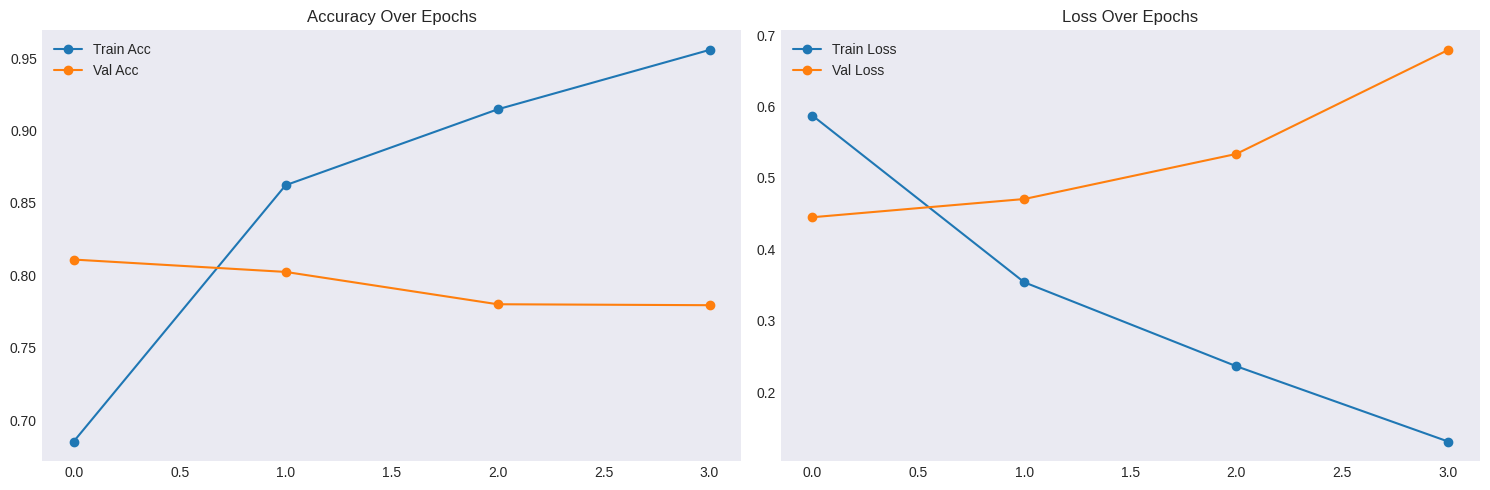

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Classification Metrics:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       869
           1       0.85      0.68      0.75       654

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.82      0.81      0.81      1523



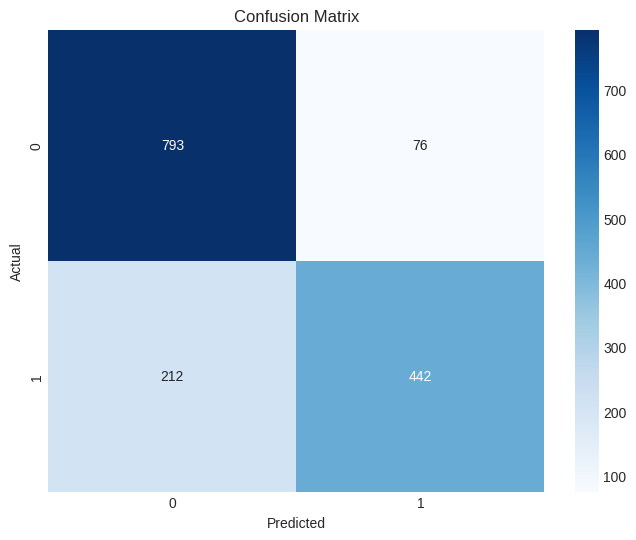

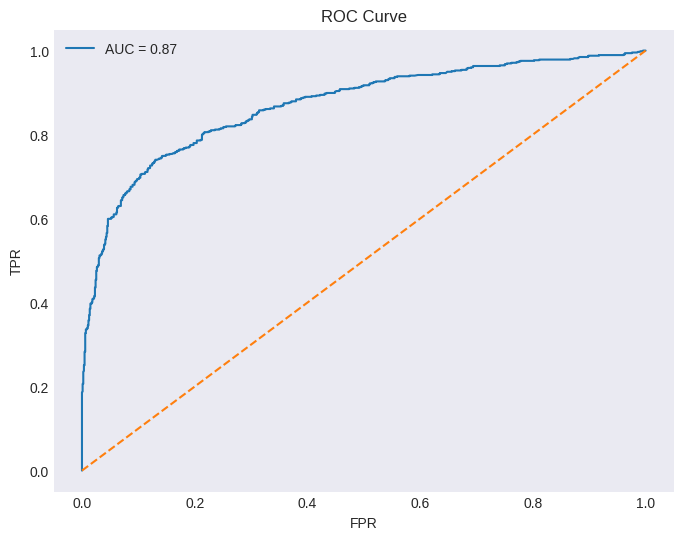

Final Train Accuracy: 0.9557
Final Val Accuracy: 0.7794


In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(training_history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Train Loss', marker='o')
plt.plot(training_history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

y_pred_prob = classifier.predict(X_val)
y_pred_label = (y_pred_prob > 0.5).astype(int)

print("Classification Metrics:")
print(classification_report(y_val, y_pred_label))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_label), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_prob)
roc_val_auc = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, label=f"AUC = {roc_val_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

print(f"Final Train Accuracy: {training_history.history['accuracy'][-1]:.4f}")
print(f"Final Val Accuracy: {training_history.history['val_accuracy'][-1]:.4f}")


## Conclusion

The evaluation of our model shows an overall accuracy of 81% on the validation set. The detailed classification metrics indicate that while class 0 (non-disaster tweets) is well-detected—with a precision of 0.79, recall of 0.91, and an F1-score of 0.85—our performance on class 1 (disaster tweets) is less robust, with a precision of 0.85 but a lower recall of 0.68 (F1-score of 0.75). This suggests that although the model generally makes correct positive predictions, it misses a significant portion of the disaster-related tweets, which could be critical in real-world applications.

Additionally, our training plots reveal that while the training loss consistently decreased, the validation loss started increasing after a certain number of epochs. This divergence indicates that our model may be overfitting the training data — it learns the training patterns very well but fails to generalize effectively to unseen examples.

**Potential Improvements:**
- **Regularization Techniques:** Increasing the dropout rate or introducing additional regularization layers could help reduce overfitting.
- **Model Complexity:** Simplifying the model by reducing the number of layers or LSTM units could prevent the model from fitting too closely to the training data.
- **Early Stopping:** Implementing early stopping more aggressively can prevent the model from training well beyond the point where validation performance peaks.
- **Data Augmentation:** Augmenting the training data or leveraging techniques like cross-validation might lead to better generalization.
- **Pre-trained Word Embeddings:** Incorporating pre-trained embeddings (such as GloVe or Word2Vec) could improve the model’s understanding of contextual word semantics, further boosting performance.
- **Hyperparameter Tuning:** Extending the hyperparameter search to include more configurations (e.g., different learning rates, batch sizes, or activation functions) could help identify a better model setup.

In summary, while our model achieves a decent performance, especially for the non-disaster class, further steps to address overfitting and enhance the detection of disaster-related tweets are recommended. These improvements could lead to a more robust and reliable system, better suited for practical applications.


In [19]:
final_predictions = (classifier.predict(pad_test) > 0.5).astype(int)

sub_file = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sub_file['target'] = final_predictions
sub_file.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Submission file created: submission.csv
